In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
from time import time
from scipy import stats

In [2]:
def color_map(mandelbrot, threshold):
    # Color Mandelbrot set in tints of white, black and green
    color = torch.where(mandelbrot == threshold, torch.tensor(0, device=mandelbrot.device), 1 - (mandelbrot + 1) / threshold)
    red = torch.where(color > 0.5, color, torch.tensor(0, device=mandelbrot.device))
    green = torch.where(color > 0.5, torch.tensor(1, device=mandelbrot.device), torch.tensor(0, device=mandelbrot.device))
    blue = torch.where(color > 0.5, color, torch.tensor(0, device=mandelbrot.device))

    return torch.stack((red, green, blue), dim=-1).cpu().numpy()

In [3]:
def check_points(coordinates, iterations):

    # Make PyTorch tensor on GPU to store data
    z = torch.zeros_like(coordinates, dtype=torch.complex64, device=coordinates.device)
    iterations_before_divergence = torch.zeros(coordinates.shape, dtype=torch.int16, device=coordinates.device)

    # Calculate for each coordinate in the tensor how fast it diverges, if at all
    for _ in range(iterations):
        z = z * z + coordinates
        mask = torch.abs(z) <= 2
        iterations_before_divergence += mask.to(torch.int16)
    return iterations_before_divergence

In [6]:
def randoms_in_range(min, max, n, device='cuda'):
    """ Returns n random numbers within the [min,max] range specified """
    return (torch.rand(n, device=device) * (max - min) + min)


def get_area(xmin, xmax, ymin, ymax, datapoints, threshold, mode='random', device='cuda'):
    if mode == 'grid':
        real_parts = torch.linspace(xmin, xmax, int(datapoints**0.5), device=device)
        imaginary_parts = torch.linspace(ymin, ymax, int(datapoints**0.5), device=device)
        real_parts, imaginary_parts = torch.meshgrid(real_parts, imaginary_parts)
    elif mode == 'random':
        real_parts = randoms_in_range(xmin, xmax, datapoints)
        imaginary_parts = randoms_in_range(ymin, ymax, datapoints)
    elif mode == 'lhc':
        sampler = stats.qmc.LatinHypercube(d=2)
        sample = sampler.random(datapoints)
        l_bounds = [xmin, ymin]
        u_bounds = [xmax, ymax]
        sample_scaled = torch.tensor(stats.qmc.scale(sample, l_bounds, u_bounds), dtype=torch.float32, device=device)
        real_parts = sample_scaled[:,0]
        imaginary_parts = sample_scaled[:,1]

    # Create PyTorch tensor on GPU containing all coordinates to be evaluated
    coordinates = real_parts + 1j * imaginary_parts

    # Check for each coordinate how many iterations it takes before it diverges
    mandelbrot = check_points(coordinates, threshold)

    fraction = torch.sum(torch.where(mandelbrot < threshold, torch.tensor(0, device=mandelbrot.device), torch.tensor(1, device=mandelbrot.device)) / datapoints)
    area = float(fraction * np.abs(xmax - xmin) * np.abs(ymax - ymin))
    return area

In [7]:
# Parameters for generating the Mandelbrot set
datapoints = 10_000_000
iterations = 5000

# Investigated region
ymin, ymax = -1.5, 1.5
xmin, xmax = -2, 1

sampling_mode = 'grid'
print(get_area(xmin, xmax, ymin, ymax, datapoints, iterations, sampling_mode))

sampling_mode = 'random'
print(get_area(xmin, xmax, ymin, ymax, datapoints, iterations, sampling_mode))

sampling_mode = 'lhc'
print(get_area(xmin, xmax, ymin, ymax, datapoints, iterations, sampling_mode))

1.506090760231018
1.5061860084533691
1.5084333419799805


In [8]:
# Parameters for generating the Mandelbrot set
datapoints = 1_000_000

# Investigated region
ymin, ymax = -1.5, 1.5
xmin, xmax = -2, 1
iterations_convergence = {}

sampling_mode = 'grid'
areas_grid = []
computationtime_grid = []

for iterations in np.arange(100, 20100, 500):
    start = time()
    areas_grid.append(get_area(xmin, xmax, ymin, ymax, datapoints, iterations, sampling_mode))
    end = time()
    computationtime_grid.append(end-start)

iterations_convergence[sampling_mode] = areas_grid[:]

In [9]:
sampling_mode = 'random'
areas_random = []
computationtime_random = []

for iterations in np.arange(100, 20100, 500):
    start = time()
    areas_random.append(get_area(xmin, xmax, ymin, ymax, datapoints, iterations, sampling_mode))
    end = time()
    computationtime_random.append(end-start)

iterations_convergence[sampling_mode] = areas_random[:]

In [10]:
sampling_mode = 'lhc'
areas_lhc = []
computationtime_lhc = []

for iterations in np.arange(100, 20100, 500):
    start = time()
    areas_lhc.append(get_area(xmin, xmax, ymin, ymax, datapoints, iterations, sampling_mode))
    end = time()
    computationtime_lhc.append(end-start)

iterations_convergence[sampling_mode] = areas_lhc[:]

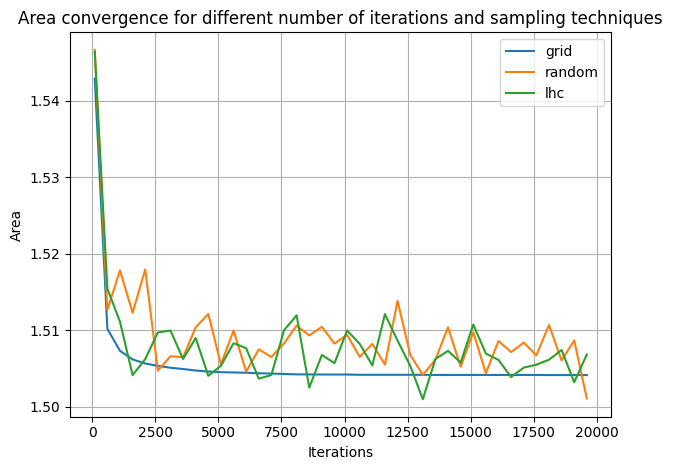

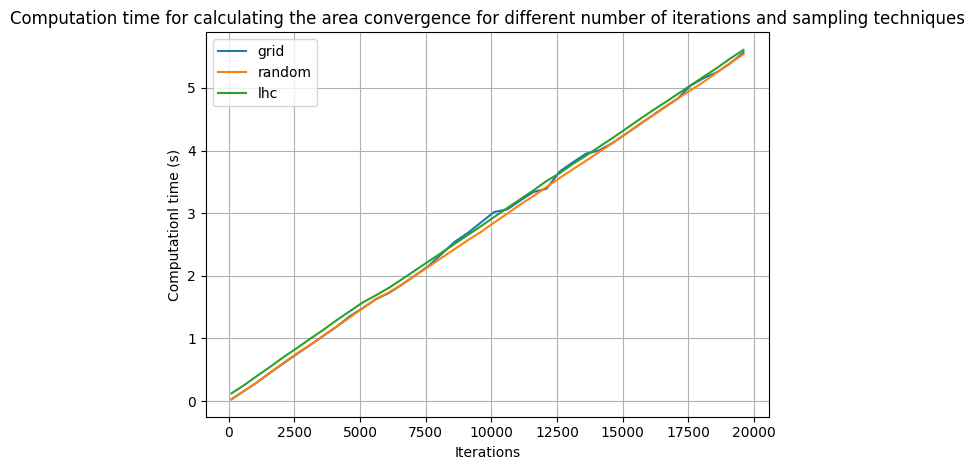

In [11]:
iterations = np.arange(100, 20100, 500)

plt.plot(iterations, iterations_convergence['grid'], label='grid')
plt.plot(iterations, iterations_convergence['random'], label='random')
plt.plot(iterations, iterations_convergence['lhc'], label='lhc')

plt.xlabel('Iterations')
plt.ylabel('Area')
plt.title('Area convergence for different number of iterations and sampling techniques')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(iterations, computationtime_grid, label='grid')
plt.plot(iterations, computationtime_random, label='random')
plt.plot(iterations, computationtime_lhc, label='lhc')

plt.xlabel('Iterations')
plt.ylabel('Computationl time (s)')
plt.title('Computation time for calculating the area convergence for different number of iterations and sampling techniques')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

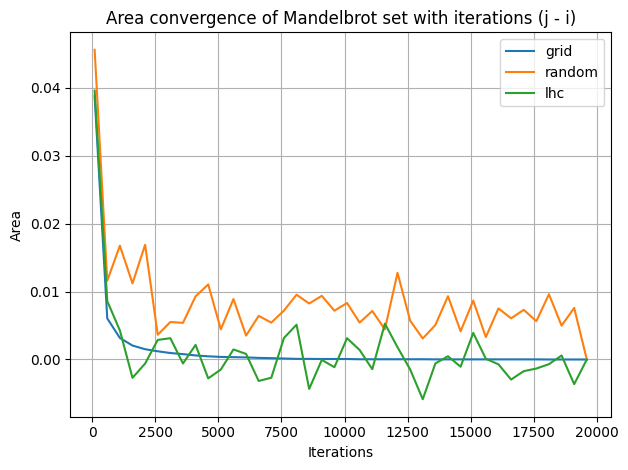

In [12]:
plt.plot(iterations, np.array(areas_grid)-areas_grid[-1], label='grid')
plt.plot(iterations, np.array(areas_random)-areas_random[-1], label='random')
plt.plot(iterations, np.array(areas_lhc)-areas_lhc[-1], label='lhc')

plt.xlabel('Iterations')
plt.ylabel('Area')
plt.title('Area convergence of Mandelbrot set with iterations (j - i)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [13]:
print(np.var(areas_grid[4:]))
print(np.var(areas_random[4:]))
print(np.var(areas_lhc[4:]))

1.2853723743539634e-07
9.204467427447197e-06
6.543876399373656e-06


In [17]:
datapoints = 1000_000
iterations = 5000

sampling_mode = 'grid'
areas_grid = []

for i in range(100):
    areas_grid.append(get_area(xmin, xmax, ymin, ymax, datapoints, iterations, sampling_mode))


In [18]:
sampling_mode = 'random'
areas_random = []

for i in range(100):
    areas_random.append(get_area(xmin, xmax, ymin, ymax, datapoints, iterations, sampling_mode))


In [19]:
sampling_mode = 'lhc'
areas_lhc = []

for i in range(100):
    areas_lhc.append(get_area(xmin, xmax, ymin, ymax, datapoints, iterations, sampling_mode))

In [20]:
def get_confidence(data, p=0.95):
    mean = np.mean(data)
    n = len(data)
    lamb = stats.t.ppf((1 + p) / 2, n-1)
    sigma = np.std(data)
    confidence = (lamb * sigma)
    return mean, confidence

In [22]:
p = 0.95

mean, confidence = get_confidence(areas_grid, p)
print(f"The area of the Mandelbrot Set is {mean} when using grid sampling")

mean, confidence = get_confidence(areas_random, p)
print(f"The area of the Mandelbrot Set is, with {100 * p}% certainty, {mean} +/-{confidence}, \n or between {mean-confidence} and {mean+confidence} when using random sampling")

mean, confidence = get_confidence(areas_lhc, p)
print(f"The area of the Mandelbrot Set is, with {100 * p}% certainty, {mean} +/-{confidence}, \n or between {mean-confidence} and {mean+confidence} when using lhc sampling")

The area of the Mandelbrot Set is 1.504565954208374 when using grid sampling
The area of the Mandelbrot Set is, with 95.0% certainty, 1.5071431291103363 +/-0.006847205254852063, 
 or between 1.5002959238554843 and 1.5139903343651884 when using random sampling
The area of the Mandelbrot Set is, with 95.0% certainty, 1.5072207844257355 +/-0.004690748238333553, 
 or between 1.5025300361874019 and 1.511911532664069 when using lhc sampling
